In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score,confusion_matrix, roc_curve, auc
import lightgbm as lgb
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2023-01-27 22:02:21.850688: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-27 22:02:21.850762: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-27 22:02:23.953990: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-27 22:02:23.954211: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-27 22:02:23.954241: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [2]:
heart_stroke_df = pd.read_csv("/home/franky/Documents/projects/heart_stroke_prediction/Notebooks/healthcare-dataset-stroke-data.csv")

In [8]:
"""
bmi is the only feature with missing values and a very low percentage.
I'm going to apply imputation unsing the average value
"""
impute = SimpleImputer(strategy='mean')
heart_stroke_df['bmi'] = impute.fit_transform(heart_stroke_df[['bmi']])


In [3]:
###let's separate target from other features###
features = heart_stroke_df.drop(["stroke"], axis=1)
features = features.drop(["id"], axis=1) #id won't be useful for models' predictions
target = heart_stroke_df.stroke

In [4]:
### Split in train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=100, stratify=target)

In [79]:
features = features.astype({"hypertension": 'str', "heart_disease": 'str'}) # I changed to string beacuse both are binary classified


### Now I separated in Numerical and Categorical Features
categorical_features = list(features.select_dtypes(include=['object']).columns)
numerical_features = list(features.select_dtypes(exclude=['object']).columns)


I will perform feature engineering using pipelines


In [80]:
###### Pipeline for numeric features ######
#### input all and scale ####

numeric_pipeline = Pipeline(steps=[         #pipeline for standarization for numerical features
    ("impute", SimpleImputer(strategy='mean')),
    ("standarization", StandardScaler())
])

categoric_pipeline = Pipeline(steps=[
    ("encoding", OneHotEncoder(handle_unknown='ignore', sparse=False, drop='if_binary')),   #pipeline for standarization for numerical features
])

# We merge both pipeline into one single pre-processing object
# We use ColumnTransformer for this
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('categories', categoric_pipeline, categorical_features)
])

In [83]:
###### Let's define X_train_prep #####

X_train_prep = full_processor.fit_transform(X_train)
X_test_prep = full_processor.transform(X_test)

In [170]:
X_train_prep.shape

(4088, 19)

#### Model Evaluation


##### Logistic Regression

Now I will choose logistic regression as a base model

In [82]:
log_reg = LogisticRegression() 
log_reg.fit(X_train_prep,y_train)

LogisticRegression()

In [86]:
log_reg_predict = log_reg.predict(X_test_prep)

In [87]:
print(classification_report(y_test, log_reg_predict))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



/home/franky/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/franky/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/franky/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
predlr = log_reg.predict_proba(X_test_prep)[:, 1]
lr_roc_auc =roc_auc_score(y_test, predlr)
lr_roc_auc

0.8275720164609054

##### Logistic Regression + RandomizedSearchCV

In [89]:
param_lr = {
     "max_iter": (100,200,500),
     "tol": (1e-4,1e-5,1e-3,1e-2),
     "C": (0.1,1,10,20)
}

In [90]:
lr_model2 = RandomizedSearchCV(LogisticRegression(random_state=100), param_lr, n_iter=20, random_state=100, cv=4,n_jobs=-1,verbose=1)

lr_model2.fit(X_train_prep,y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


/home/franky/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franky/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

RandomizedSearchCV(cv=4, estimator=LogisticRegression(random_state=100),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'C': (0.1, 1, 10, 20),
                                        'max_iter': (100, 200, 500),
                                        'tol': (0.0001, 1e-05, 0.001, 0.01)},
                   random_state=100, verbose=1)

In [91]:
lr_pred = lr_model2.predict(X_test_prep)

In [92]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



/home/franky/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/franky/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/franky/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
predlr2 = lr_model2.predict_proba(X_test_prep)[:, 1]
lr_roc_auc =roc_auc_score(y_test, predlr2)
lr_roc_auc

0.8292386831275721

##### Random Forest Classifier

In [100]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_prep,y_train)

RandomForestClassifier()

In [101]:
rf_pred_test = rf_model.predict(X_test_prep)

In [102]:
print(classification_report(y_test, rf_pred_test))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



In [103]:
predrf=rf_model.predict_proba(X_test_prep)[:, 1]
lr_roc_auc =roc_auc_score(y_test, predrf)
lr_roc_auc

0.7898148148148149

##### Random Forest Classifier + RandomizedSearchCV

In [104]:
param_dist = {
     'criterion': ('gini', 'entropy'),
     'n_estimators':  np.random.randint(1,100,20),
     'max_depth': np.random.randint(1,15,10),
     'max_features': ('auto', 'log2'),
     'min_samples_split': np.random.randint(1,15,10),
     'min_samples_leaf': np.random.randint(1,15,10)
}

In [105]:
rf_model2 = RandomizedSearchCV(RandomForestClassifier(random_state=100), param_dist, n_iter=20, random_state=100, cv=4,n_jobs=-1,verbose=1)

rf_model2.fit(X_train_prep,y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


/home/franky/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/franky/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/franky/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the 

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(random_state=100),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ('gini', 'entropy'),
                                        'max_depth': array([ 7, 10, 10,  1, 10,  9,  2,  3,  1, 13]),
                                        'max_features': ('auto', 'log2'),
                                        'min_samples_leaf': array([ 5, 10,  1,  8,  8, 10,  3, 10,  6,  6]),
                                        'min_samples_split': array([10, 14,  2,  3,  3,  6,  7,  9,  5, 11]),
                                        'n_estimators': array([39, 27, 32, 23, 92, 98, 40,  4, 56, 60, 87, 22, 25, 72, 96,  9, 58,
       39, 25, 24])},
                   random_state=100, verbose=1)

In [106]:
rf_pred_test2 = rf_model2.predict(X_test_prep)

In [108]:
print(classification_report(y_test, rf_pred_test2))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



/home/franky/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/franky/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/franky/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [109]:
predrf2=rf_model2.predict_proba(X_test_prep)[:, 1]
lr_roc_auc =roc_auc_score(y_test, predrf)
lr_roc_auc

0.7898148148148149

##### LGBM Classifier + RandomizedSearchCV

In [113]:
lgbm_params = {
        'bagging_fraction':(0.3,0.6,0.8,1),
        'feature_fraction': (0.3,0.5,0.8,1),
        'max_depth': np.random.randint(5, 200,10),
        'min_data_in_leaf': np.random.randint(5, 100,10),
        'num_leaves': np.random.randint(5, 100,10)
}

In [116]:
lgbm_model = RandomizedSearchCV(lgb.LGBMClassifier(random_state=100),scoring='roc_auc', param_distributions=lgbm_params, cv = 5, n_iter = 5,verbose=1) 
lgbm_model.fit(X_train_prep,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current v

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=100), n_iter=5,
                   param_distributions={'bagging_fraction': (0.3, 0.6, 0.8, 1),
                                        'feature_fraction': (0.3, 0.5, 0.8, 1),
                                        'max_depth': array([ 29,  65, 158, 179,  23, 183, 142, 124, 195,  28]),
                                        'min_data_in_leaf': array([82, 83, 78, 48, 94, 85, 44, 14, 55, 61]),
                                        'num_leaves': array([38, 45, 79, 49, 26,  8, 48, 32, 97, 32])},
                   scoring='roc_auc', verbose=1)

In [117]:
lgbm_pred_test = lgbm_model.predict(X_test_prep)

In [119]:
print(classification_report(y_test, lgbm_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.29      0.04      0.07        50

    accuracy                           0.95      1022
   macro avg       0.62      0.52      0.52      1022
weighted avg       0.92      0.95      0.93      1022



In [124]:
predlgbm = lgbm_model.predict_proba(X_test_prep)[:, 1]
lr_roc_auc = roc_auc_score(y_test, predlgbm2)
lr_roc_auc

0.8523765432098764

##### XGBoost 

In [125]:
xgb_model = XGBClassifier()

xgb_model.fit(X_train_prep, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [126]:
xgb_pred_test = xgb_model.predict(X_test_prep)

In [127]:
print(classification_report(y_test, xgb_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.31      0.08      0.13        50

    accuracy                           0.95      1022
   macro avg       0.63      0.54      0.55      1022
weighted avg       0.92      0.95      0.93      1022



In [129]:
predxgb = xgb_model.predict_proba(X_test_prep)[:, 1]
xgb_roc_auc = roc_auc_score(y_test, predxgb)
xgb_roc_auc

0.8317901234567902

In [130]:
predxgb

array([2.48559914e-03, 1.62925348e-01, 4.83383221e-04, ...,
       2.18504196e-04, 1.07490805e-05, 2.20729798e-05], dtype=float32)

/home/franky/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


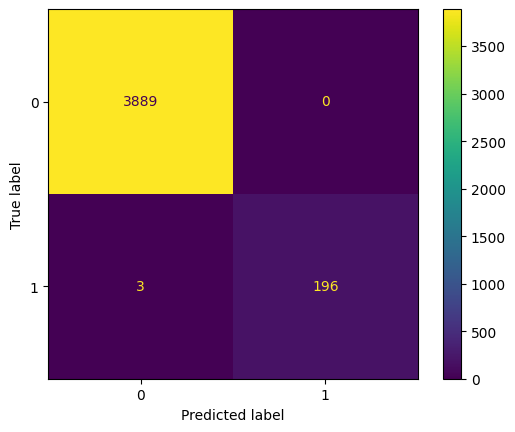

In [131]:
plot_confusion_matrix(xgb_model, X_train_prep, y_train)

/home/franky/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


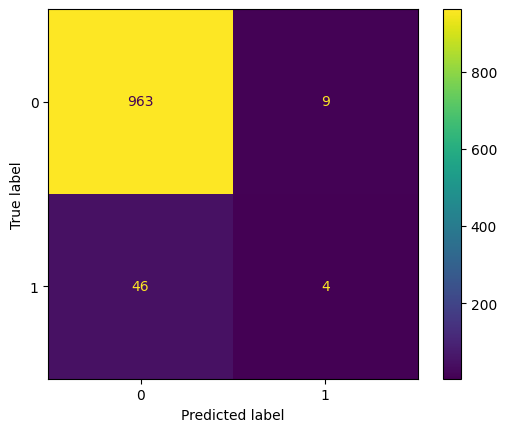

In [132]:
plot_confusion_matrix(xgb_model, X_test_prep, y_test)

[0.         0.00102881 0.00102881 0.00514403 0.00514403 0.00617284
 0.00617284 0.00823045 0.00823045 0.01028807 0.01028807 0.01131687
 0.01131687 0.01748971 0.01748971 0.01954733 0.01954733 0.02263374
 0.02263374 0.03497942 0.03497942 0.03600823 0.03600823 0.03806584
 0.03806584 0.04423868 0.04423868 0.05041152 0.05041152 0.05761317
 0.05761317 0.06378601 0.06378601 0.06481481 0.06481481 0.08436214
 0.08436214 0.09053498 0.09053498 0.10493827 0.10493827 0.1100823
 0.1100823  0.11728395 0.11728395 0.11831276 0.11831276 0.11934156
 0.11934156 0.1244856  0.1244856  0.12860082 0.12860082 0.1409465
 0.1409465  0.15226337 0.15226337 0.19444444 0.19444444 0.20473251
 0.20473251 0.20987654 0.20987654 0.21090535 0.21090535 0.23353909
 0.23353909 0.25411523 0.25411523 0.25925926 0.25925926 0.28909465
 0.28909465 0.29320988 0.29320988 0.31069959 0.31069959 0.33127572
 0.33127572 0.33436214 0.33436214 0.33950617 0.33950617 0.34259259
 0.34259259 0.36831276 0.36831276 0.38374486 0.38374486 0.543209

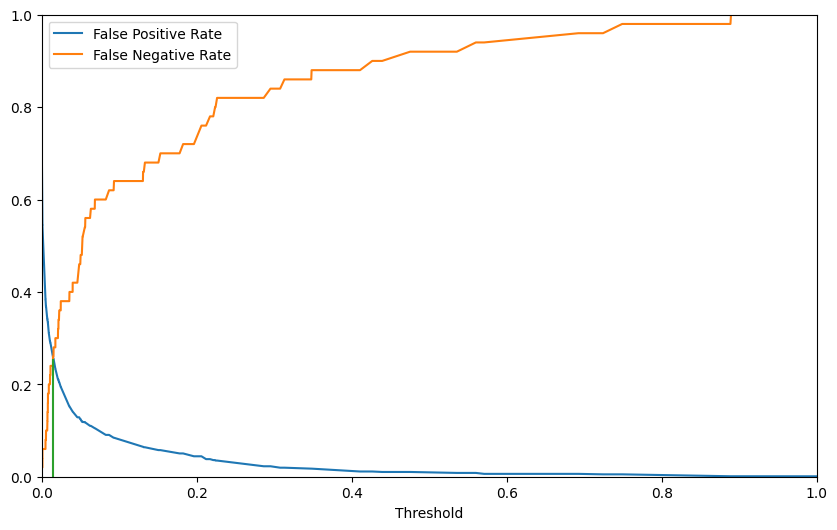

In [160]:
"""
False Positive Rate and False Negative Rate against the Threshold
"""

predxgb=xgb_model.predict_proba(X_test_prep)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, predxgb)
print(fpr)
print(tpr)
dfplot=pd.DataFrame({'Threshold':thresholds,'False Positive Rate':fpr,'False Negative Rate': 1.-tpr})
ax=dfplot.plot(x='Threshold', y=['False Positive Rate','False Negative Rate'], figsize=(10,6))
ax.plot([0.0148,0.0148],[0,0.252]) 
ax.set_xbound(0,1); ax.set_ybound(0,1) 

[0.         0.00102881 0.00102881 0.00514403 0.00514403 0.00617284
 0.00617284 0.00823045 0.00823045 0.01028807 0.01028807 0.01131687
 0.01131687 0.01748971 0.01748971 0.01954733 0.01954733 0.02263374
 0.02263374 0.03497942 0.03497942 0.03600823 0.03600823 0.03806584
 0.03806584 0.04423868 0.04423868 0.05041152 0.05041152 0.05761317
 0.05761317 0.06378601 0.06378601 0.06481481 0.06481481 0.08436214
 0.08436214 0.09053498 0.09053498 0.10493827 0.10493827 0.1100823
 0.1100823  0.11728395 0.11728395 0.11831276 0.11831276 0.11934156
 0.11934156 0.1244856  0.1244856  0.12860082 0.12860082 0.1409465
 0.1409465  0.15226337 0.15226337 0.19444444 0.19444444 0.20473251
 0.20473251 0.20987654 0.20987654 0.21090535 0.21090535 0.23353909
 0.23353909 0.25411523 0.25411523 0.25925926 0.25925926 0.28909465
 0.28909465 0.29320988 0.29320988 0.31069959 0.31069959 0.33127572
 0.33127572 0.33436214 0.33436214 0.33950617 0.33950617 0.34259259
 0.34259259 0.36831276 0.36831276 0.38374486 0.38374486 0.543209

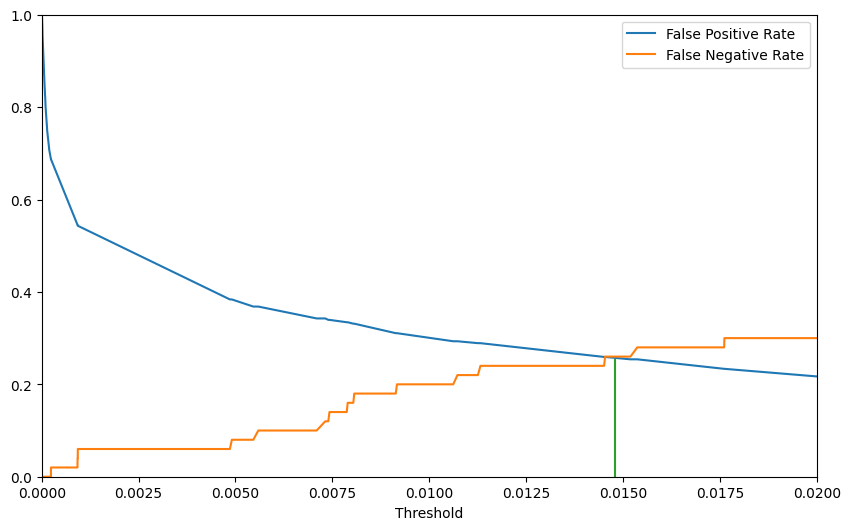

In [159]:
"""
False Positive Rate and False Negative Rate against the Threshold
"""

predxgb=xgb_model.predict_proba(X_test_prep)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, predxgb)
print(fpr)
print(tpr)
dfplot=pd.DataFrame({'Threshold':thresholds,'False Positive Rate':fpr,'False Negative Rate': 1.-tpr})
ax=dfplot.plot(x='Threshold', y=['False Positive Rate','False Negative Rate'], figsize=(10,6))
ax.plot([0.0148,0.0148],[0,0.252]) 
ax.set_xbound(0,0.02); ax.set_ybound(0,1) 

In [163]:
predxgb[predxgb >= 0.015] = 1
predxgb[predxgb < 0.015] = 0


In [164]:
print(classification_report(y_test, predxgb))

              precision    recall  f1-score   support

           0       0.98      0.74      0.85       972
           1       0.13      0.74      0.22        50

    accuracy                           0.74      1022
   macro avg       0.56      0.74      0.53      1022
weighted avg       0.94      0.74      0.82      1022



##### MLP

In [184]:
model_mlp = keras.Sequential()
model_mlp.add(layers.Dense(8, input_dim=19, activation='relu'))
model_mlp.add(layers.Dense(4, activation='relu'))
model_mlp.add(layers.Dense(2, activation='softmax'))

model_mlp.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 8)                 160       
                                                                 
 dense_12 (Dense)            (None, 4)                 36        
                                                                 
 dense_13 (Dense)            (None, 2)                 10        
                                                                 
Total params: 206
Trainable params: 206
Non-trainable params: 0
_________________________________________________________________


In [185]:
model_mlp.compile(
  loss='sparse_categorical_crossentropy', 
  optimizer='adam',
  metrics=['accuracy'],
)

In [186]:
early_stopping = keras.callbacks.EarlyStopping(
patience=5,
min_delta=0.001,
restore_best_weights=True,
)

In [187]:
model_mlp.fit(
  X_train_prep, 
  y_train, 
  epochs=50, 
  batch_size=32, 
  validation_split=0.2,
  callbacks=[early_stopping]
)

Epoch 1/50
103/103 [==============================] - 3s 11ms/step - loss: 0.3630 - accuracy: 0.9505 - val_loss: 0.2327 - val_accuracy: 0.9548
Epoch 2/50
103/103 [==============================] - 1s 5ms/step - loss: 0.2108 - accuracy: 0.9505 - val_loss: 0.1860 - val_accuracy: 0.9548
Epoch 3/50
103/103 [==============================] - 1s 5ms/step - loss: 0.1837 - accuracy: 0.9505 - val_loss: 0.1730 - val_accuracy: 0.9548
Epoch 4/50
103/103 [==============================] - 1s 5ms/step - loss: 0.1728 - accuracy: 0.9505 - val_loss: 0.1679 - val_accuracy: 0.9548
Epoch 5/50
103/103 [==============================] - 1s 5ms/step - loss: 0.1670 - accuracy: 0.9505 - val_loss: 0.1661 - val_accuracy: 0.9548
Epoch 6/50
103/103 [==============================] - 1s 7ms/step - loss: 0.1631 - accuracy: 0.9505 - val_loss: 0.1644 - val_accuracy: 0.9548
Epoch 7/50
103/103 [==============================] - 0s 5ms/step - loss: 0.1602 - accuracy: 0.9505 - val_loss: 0.1637 - val_accuracy: 0.9548
Epoch

In [188]:
mlp_pred_test = model_mlp.predict(X_test_prep)

32/32 [==============================] - 0s 4ms/step


In [189]:
y_pred_bool = np.argmax(mlp_pred_test, axis=1)

In [190]:
print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



/home/franky/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/franky/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/franky/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
